In [8]:
# load the raw dataset of companies

import pandas as pd
import numpy as np
import pickle
import pyautogui as pg

dir_data = '~/kernel/thesis/data/cbm/'
name_csv = 'cbm_transaction.csv'
df_cbm = pd.read_csv(dir_data + name_csv)

def cols2unique(df, columns):
    '''
    Gets values from columns, puts them together and returns an array of unique values
    '''
    columns_locs = []
    for column in columns:
        columns_locs.append(pd.Series(df[column]))
    locs = pd.concat(columns_locs)
    unique_array = locs.unique()
    return unique_array

companies = cols2unique(df_cbm, columns=['ac_name','mc_name','ac_name_of_group'])
ac_groups = cols2unique(df_cbm, columns=['ac_name_of_group'])

df_cbm.head()

,Transaction_id,Transaction_date,ac_name,ac_location,ac_registration_number,ac_name_of_group,mc_name,mc_location,mc_registration_number
0,1,2013-04-26,Immobilaire Effetti S.R.L.,Belgium,12326610156,Immobilaire Effetti S.R.L.,Luforden B.V.,Finland,12326610156
1,1,2013-04-26,Immobilaire Effetti S.R.L.,Italy,12326610156,Immobilaire Effetti S.R.L.,Luforden B.V.,Finland,12326610156
2,1,2013-04-26,Immobilaire Effetti S.R.L.,Belgium,12326610156,Immobilaire Effetti S.R.L.,Luforden B.V.,Netherlands,12326610156
3,1,2013-04-26,Immobilaire Effetti S.R.L.,Italy,12326610156,Immobilaire Effetti S.R.L.,Luforden B.V.,Netherlands,12326610156
4,2,2017-10-24,ABN AMRO Commercial Finance Holding B.V.,Belgium,24263820,ABN AMRO Commercial Finance Holding B.V.,ABN AMRO Commercial Finance Plc,Sweden,24263820


In [7]:
# (OPTIONAL) normalization of strings (decode accents etc)

def normalize_strings_in_list(some_list, accept_artifacts = False):
    companies = some_list
    decoded_companies = []
    for company in companies:
        trigger = False
        decoded = unidecode.unidecode(company)
        #normal = unicodedata.normalize('NFKD', company).encode('ASCII', 'ignore')
        decoded = decoded.split(' ')
        for word in decoded:
            if 'NULL' in word:
                decoded.remove(word)
                trigger=True
        decoded = ' '.join(decoded)
        # turns out ORBIS search doesn't work if its anything else
        if trigger==False or accept_artifacts==True:
            decoded_companies.append(decoded)
    return some_list

companies = normalize_strings_in_list(companies, accept_artifacts = False)

NameError: name 'unidecode' is not defined

In [9]:
# create dictionary of names

import unidecode, unicodedata, pprint, time

dir_path = '/home/op/kernel/thesis/data/orbis/'

dict_num2comp= {str(hash(name))[-10:-1]:name for name in companies}
dict_comp2num= {name:str(hash(name))[-10:-1] for name in companies}
pickle.dump(dict_num2comp, open(dir_path+'dict_num2comp.pickle','wb+'))
pickle.dump(dict_comp2num, open(dir_path+'dict_comp2num.pickle','wb+'))
#pprint.pprint(dict_num2comp)

In [12]:
# make df of companies

d = {index:{'company':dict_num2comp[index],'country':'','role':'','role_flag':'','transactions':''} for index in dict_num2comp}
df_companies = pd.DataFrame.from_dict(d, orient='index')
df_companies.head()

role_dict = {'ac_name':'AC','mc_name':'MC','ac_name_of_group':'GUO'}

for index in df_cbm.index:
    transaction_id = df_cbm.at[index, 'Transaction_id']
    for column in ['ac_name','mc_name','ac_name_of_group']:
        field = df_cbm.at[index, column]
        role = role_dict[column]
        if df_companies.at[dict_comp2num[field],'role'] not in [role,'']:
            df_companies.at[dict_comp2num[field],'role_flag']=df_companies.at[dict_comp2num[field],'role_flag']+df_companies.at[dict_comp2num[field],'role']
        df_companies.at[dict_comp2num[field],'role']=role
        df_companies.at[dict_comp2num[field], 'transactions'] = df_companies.at[dict_comp2num[field], 'transactions'] + str(transaction_id)+','
        
        df_companies.at[dict_comp2num[df_cbm.at[index, 'ac_name']], 'country'] = df_cbm.at[index, 'ac_location']
        df_companies.at[dict_comp2num[df_cbm.at[index, 'mc_name']], 'country'] = df_cbm.at[index, 'ac_location']
df_companies.head()

,company,country,role,role_flag,transactions
000488369,ING Groep NV,,GUO,,"809,"
000491118,FormeNULLLimited,Italy,MC,,"685,"
000657761,Rock Fixtures S.à.r.l.,Germany,MC,,"2421,"
000730245,lronbridge Il Luxembourg Holdings 2 S.à.r.l.,Luxembourg,GUO,AC,"1589,1589,"
001048023,Total (BTC) S.à r.l.,Netherlands,MC,,"98,98,98,98,"


In [13]:
df_companies[df_companies['role_flag']!='']

,company,country,role,role_flag,transactions
000730245,lronbridge Il Luxembourg Holdings 2 S.à.r.l.,Luxembourg,GUO,AC,"1589,1589,"
003906900,CMOG Treuhand I GmbH,Luxembourg,MC,ACGUO,"1903,1903,1911,"
003974897,Maluja B.V.,Netherlands,GUO,AC,"2328,2328,"
004971480,JetVerse B.V.,Netherlands,GUO,AC,"201,201,"
005267917,Deciding Trading Limited,Cyprus,GUO,AC,"2114,2114,"
008112422,Xior Student Housing NV,Belgium,GUO,ACGUOAC,"1826,1827,1828,1830,1831,1832,1836,1837,1838,1..."
008714777,DOT S.A.,Luxembourg,GUO,AC,"2550,2550,"
008849725,"Cheper Invest, as",Czech Republic,GUO,AC,"2145,2145,"
009103809,Slobel SPRL,Belgium,GUO,AC,"845,845,"
010217884,MOL West Oman B.V.,Netherlands,GUO,AC,"144,144,"


In [16]:
# SCRAPER get search results
from PIL import Image
import pytesseract, os
images = []
dir_path = '/home/op/kernel/thesis/data/orbis/ocr/'


def get_company(company):
    pg.moveTo(293,237)
    pg.click()
    pg.hotkey('ctrl','a')
    pg.press('delete')
    pg.typewrite(company, interval=0.1)
    #print(company)
    time.sleep(6)
    file_name = dict_comp2num[str(company)]
    im = pg.screenshot(dir_path+file_name+'.png',region=(77, 256, 710, 552))
    text= pytesseract.image_to_string(Image.open(dir_path+file_name+'.png'))
    #images.append(text)
    with open(dir_path+file_name+'.png.txt','w') as f:
        f.write(text)
    pass


import os
file_names = []
for file in os.listdir(dir_path):
    # append all files names to a list
    if file[0]!='.' and file[-3:]=='png': #to handle issue with hidden files and non-pdf files
        file_names.append(file[:-4])
file_names

counter = 0

for number in dict_num2comp.keys():
    if number not in file_names:
        get_company(dict_num2comp[number])
        print(counter, number, dict_num2comp[number])
    counter+=1


FileNotFoundError: [Errno 2] No such file or directory: '/home/op/kernel/thesis/data/orbis/ocr/'

In [228]:
# data processing of first scraper 
import pandas as df

for file in os.listdir(dir_path):
    # append all files names to a list
    if file[0]!='.' and file[-3:]=='png': #to handle issue with hidden files and non-pdf files
        file_names.append(file[:-4])
file_names

corpnet_id = {'0':list(dict_num2comp.keys())}
text = {name:None for name in dict_num2comp.keys()}
for file in file_names:
    with open(dir_path+file+'.png.txt') as f:
        text[file]=f.read()

df_companies = pd.concat([
                        pd.DataFrame.from_dict(dict_num2comp, orient='index',columns=['name']),
                        pd.DataFrame.from_dict(text, orient='index',columns=['text']), 
                        #pd.DataFrame.from_dict(dict(G.out_degree()), orient='index',columns=['text']),
                         ], axis=1, join='outer')
df_companies.to_csv('/home/op/kernel/thesis/data/orbis/all_texts.csv')
text = df_companies.loc['021676583','text']
df_companies.head()

FileNotFoundError: [Errno 2] No such file or directory: '/home/op/kernel/thesis/data/orbis/185925173.png.txt'

In [58]:
# find which names have NULL
null_names = []
for name in df_companies['name']:
    if 'NULL' in name:
        null_names.append(name)
        print(name)
        
len(null_names)

GoNULLez Byass, S.A.
RouNULLout Tours B.V.
SaNULLossa Capital Investments B.V.
SeNULL Corporation S.L.
General Mills Luxembourg FiNULLce S.a r.l
Harsco International FiNULLce S.a r.l.
RheiNULLd Versicherungs AG
Oriola FiNULLd Oy
Belfius FiNULLcing Company
Volkswagen FiNULLce Luxemburg S.A.
Societe Generale Capital Market FiNULLce eNULLrege SGCMF
Atlantic CoNULLner Line AB
GAZPROM GermaNULLGmbH
Yellow MouNULLn S.a r.l.
FiNULLcial Performance Holdings B.V.
SaNULL Investment Holdings UK Limited
BiNULLle International Corporation B.V.
Telecom Italia FiNULLce
Chiquita BaNULLa Company B.V. (now Chiquita Europe B.V.)
Robert Bosch FiNULLce Nederland B.V.
Robert Bosch IC FiNULLcing Nederland B.V.
Endo Global FiNULLce S.a r.l. LLC (dissolved)
GKI-OFU IndustrieofeNULL GmbH (now Thyssenkrupp Fertilizier Technology Gmbh)
DreNULL Limited
der HyuNULL Logistics (UK) Holdings Ltd. [now Lotte Global Logistics (UK) Holdings CO., LTD.]
Zeus CMBS FiNULLce Limited
PenaNULLB.V.
eBay KleiNULLzeigen GmbH
Thyss

288

In [ ]:
import pandas_profiling
df_companies.profile_report()

In [ ]:
PART 2


In [14]:
#df = df_companies[df_companies['country'].isin(['Netherlands','Estonia','Finland','Germany','Luxembourg','Sweden','Poland','Italy'])]
df = df_companies.copy()
#df = df[df['role'].isin(['GUO','AC'])]
df['score']=df['role_flag'].str.len()
df_companies_filtered= df.sort_values(by='score', ascending=False)
df_companies_filtered = df_companies_filtered.drop(columns = ['role_flag','transactions'])
df_companies_filtered.to_csv('/home/op/kernel/thesis/data/orbis/companies.csv')
df_companies_filtered

,company,country,role,score
737432500,Octopus Liegenschaftsverwaltungsgesellschaft m...,Austria,GUO,107
281236465,Aleris Aluminum Vogt GmbH,Denmark,GUO,57
125210818,EPF Neli OÜ,Estonia,GUO,52
010385542,Treveria D S.à r.l.,Luxembourg,GUO,42
413788916,Venetsalo Holdings Limited,Cyprus,GUO,37
560460488,PoloNULLProperty S.à rl,Luxembourg,GUO,22
773049444,RP Complex Holding S.à.r.l.,Luxembourg,GUO,22
994330807,Nordea Bank AB (publ),Finland,GUO,22
510880349,Virvi B.V.,Netherlands,GUO,22
883274265,Viega Holding GmbH & Co. KG,Germany,GUO,22


In [292]:
for file in os.listdir(dir_path):
    # append all files names to a list
    if file[0]!='.' and file[-3:]=='png': #to handle issue with hidden files and non-pdf files
        file_names.append(file[:-4])
file_names

['904439362', '014731448', '904439362', '014731448']

In [325]:
df_companies_filtered.shape

(3213, 4)

In [15]:
#191029 Getting ownership info
import os
dir_path = '/home/op/kernel/thesis/data/orbis/ocr_ownership/'
dir_buttons = '/home/op/kernel/thesis/data/orbis/buttons/'

ui = { 'search_button' : (27,263),
         'search_bar' : (199,250),
         'first_search_result' : (175,325),
         'new_search_confirm': (674, 506)}

file_names = []

for file in os.listdir(dir_path):
    # append all files names to a list
    if file[0]!='.' and file[-3:]=='png': #to handle issue with hidden files and non-pdf files
        file_names.append(file[:-4])
print(len(file_names), df_companies.shape)
with open(dir_path+'tainted.txt','r') as f:
    for line in f.readlines():
        file_names.append(line[:-1])
print(len(file_names), df_companies.shape)

for index in df_companies_filtered.index:
    #print(index)
    if index not in file_names:
        company = df_companies.at[index, 'company']
        pg.moveTo(ui['search_button'])
        pg.click()
        time.sleep(4)
        pg.moveTo(ui['search_bar'])
        pg.click()
        pg.hotkey('ctrl','a')
        pg.press('delete')
        pg.typewrite(company, interval=0.1)
        pg.moveTo(ui['first_search_result'])
        time.sleep(5)
        pg.click()
        pg.moveTo(ui['new_search_confirm'])
        time.sleep(3)
        pg.click()
        time.sleep(5)
        loc = pg.locateOnScreen(dir_buttons+'ownership_more.png')
        if loc!=None:
            location = (loc[0]+20,loc[1]+45,280,60)
            im = pg.screenshot(dir_path+index+'.png',region=location)
            ownership = pytesseract.image_to_string(Image.open(dir_path+index+'.png'))
            with open(dir_path+index+'.png.txt','w') as f:
                f.write(company)
                f.write('\r\n')
                f.write(ownership)
            im = pg.screenshot(dir_path+index+'.png',region=(300,130,950,920))
            print(company)
            print(ownership)
        else:
            with open(dir_path+'tainted.txt','a+') as f:
                f.write(index)
                f.write('\r\n')

3778 (5890, 5)
5890 (5890, 5)


NameError: name 'pytesseract' is not defined

In [ ]:
from PIL import Image
import pytesseract
images = []
dir_path = '/home/op/kernel/thesis/data/orbis/ocr/'


def get_company(company):
    pg.moveTo(293,237)
    pg.click()
    pg.hotkey('ctrl','a')
    pg.press('delete')
    pg.typewrite(company, interval=0.1)
    #print(company)
    time.sleep(6)
    file_name = dict_comp2num[str(company)]
    im = pg.screenshot(dir_path+file_name+'.png',region=(77, 256, 710, 552))
    text= pytesseract.image_to_string(Image.open(dir_path+file_name+'.png'))
    #images.append(text)
    with open(dir_path+file_name+'.png.txt','w') as f:
        f.write(text)
    pass
    
print(images)

In [80]:
get_company()

name BLACKROCK. INC
location NEW YORK, NY, United States of Amé
guo Publicly quoted
This company is the Global Ultimate Owner of the corporate group
activity Finance company (credit card
full_address 55 EAST S2ND STREET,PAR
NEW YORK, NY, NY 10055-C
United States of America
incorporation_date 
ownership More :

‘Ownership


In [78]:
# when executed records the position of the mouse for how_many_seconds
import pyautogui as pg
import time

how_many_seconds = 5

def record():
    t = time.time()
    r = []
    while((time.time()-t)< how_many_seconds):
        time.sleep(2)
        r.append(pg.position())
        print(r[-1])
    return r
#pg.dragTo(50,50)
pg.click()
r = record()

Point(x=1843, y=317)
Point(x=674, y=506)
Point(x=1800, y=501)


In [69]:
regions = {'name': (402, 254, 163, 20),
           'location': (401, 283, 219, 17),
           'guo':(623, 325, 474, 38),
           'activity': (778, 455, 351, 19),
           'full_address': (329, 449, 165, 65),
           'incorporation_date': (780, 477, 246, 16),
           'ownership': (330, 681, 268, 85)
          }


from PIL import Image
import pytesseract
images = []
dir_path = '/home/op/kernel/thesis/data/orbis/ocr_tests/'


def get_company(company=None):
    for region_name in regions:
        im = pg.screenshot(dir_path+region_name+'.png',region=regions[region_name])
        text= pytesseract.image_to_string(Image.open(dir_path+region_name+'.png'))
        print(text)
        #images.append(text)
        with open(dir_path+region_name+'.png.txt','w') as f:
            f.write(text)
    pass
get_company()
#print(images)
           

name TOOLS-LENA. S.R.O.
location HRADEC KRALOVE, Czech Republic:
guo Private
The Global Ultimate Owner of this controlled subsidiary is MR JIRI VACLAVICEK
activity Corporate, Property Services
full_address POUCHOVSKA 533/524
50003 HRADEC KRALOVE
Czech Republic
incorporation_date Date of incorporation:
ownership Ownership

1 shareholder
0 subsidiary
2 companies in the corporate group


In [283]:
im = pg.screenshot(dir_path+'ownership.png',region=(316, 768, 95, 40))

2 shareholders
3 subsidiaries
29 companies in the corporate group


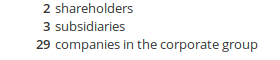

In [288]:
loc = pg.locateOnScreen(dir_buttons+'ownership_more.png')
location = (loc[0]+20,loc[1]+45,280,60)
im = pg.screenshot(dir_path+'ownership_found.png',region=location)
text= pytesseract.image_to_string(Image.open(dir_path+'ownership_found.png'))
print(text)
im
#pg.moveTo(location[0],location[1])

In [282]:
def get_region():
    print('Go!')
    time.sleep(2)
    p1 = pg.position()
    print(p1)
    time.sleep(2)
    p2 = pg.position()
    print(p2)
    region =(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1])
    print('Box :', region)
    print('Center :', (int(region[0]+region[2]/2), int(region[1]+region[3]/2)))
    print('Size: ', (region[2], region[3]))
    return region

region = get_region()

Go!
Point(x=316, y=768)
Point(x=411, y=808)
Box : (316, 768, 95, 40)
Center : (363, 788)
Size:  (95, 40)


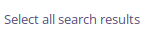

In [120]:
dir_buttons = '/home/op/kernel/thesis/data/orbis/buttons/'
im = pg.screenshot(dir_buttons+'select_all_search.png',region=(371, 731, 154, 32))
im

In [47]:
import cv2, pytesseract, imutils
cv2.imread('/home/op/kernel/thesis/data/orbis/snap.png', 0)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [130]:
# OCR that sees itself

import re
for i in range(0,10):
    t=time.time()
    im = pg.screenshot(dir_path+'test_all_screen.png')
    text= pytesseract.image_to_string(Image.open(dir_path+'test_all_screen.png'))
    match = re.findall('Oskar', text)
    see_self = re.findall('I see myself', text)
    see_this = 'I see myself '+str(len(see_self))+' times!'
    end = time.time()-t
    print(end, len(match), see_this)

3.9915666580200195 3 I see myself 12 times!
3.8526225090026855 3 I see myself 2 times!
3.899962902069092 3 I see myself 3 times!
3.8587939739227295 3 I see myself 4 times!
3.964635133743286 3 I see myself 5 times!
3.962472915649414 3 I see myself 6 times!
4.078366041183472 3 I see myself 7 times!
4.1080732345581055 3 I see myself 8 times!
4.087390184402466 3 I see myself 9 times!
4.188660383224487 3 I see myself 10 times!


In [129]:
print(text)

eee Ee Sec eee Cod

 

   

 

# Orbis|Companyinform X | Data & Analytics inM& Gi Mail- Oskar Person-O lees sland CBM_orbis_anal) X [RGMEODIEEGEREeas Robin Cowan X © pyautoguiforau' x + Advanced Python X | M Automationwit
<)> ¢@ o\a live.com “Ow snoom Ae c@ | © localhost 8 * snoom Ae Ws
ESworkspace £5 Thesis Slashdot Papers °< GeeksforGeeks {4 AutomationCourse # GoodNews —Cloud Wars @Medium [MJ Top Links| HackerNews [JIT AAI ESworkspace i Thesis 4 Slashdot Papers °< GeeksforGeeks 1 AutomationCourse # GoodNews — Cloud Wars @Medium [J TopLinks|HackerNews [IT SAI >»

 
 
 

 

eae ... VAMWELH-_AWE k WEN S jupyter CBM_orbis_scraping Last checkpoint 16 minutes ago (ansaved changes) By Logout

 

   

 

 

   

 

 

    

     

 

 

 

 

 

 

 

   

 

© Mark all as read File Edit View Insert Cell_~«Kernel_~— Widgets ‘Help Tw [Pythons @
Ey fark all as reat
B+) BB ey WRU mC coue |=
> Favorites © egFocused Other Filters cv2. imread(' /home/op/kernel/thesis/data/orbis/snap.png’, 0)
out[4

In [23]:
loc=pg.locateOnScreen(im)

In [15]:
def mcw(x,y):
    '''
    Move, click and wait!
    '''
    pg.moveTo(x,y)
    pg.click()
    time.sleep(3)

images = []

for company in companies[1:2]:
    pg.moveTo(293,237)
    pg.click()
    pg.typewrite(company)
    #pg.press('enter')
    time.sleep(3)
    #mcw(293,407)
    #mcw(590,768)
    #mcw(1642,748) #PDF button
    images.append(pg.screenshot(region=(81,215, 236, 275)))

companies[-100:-10]